# S7. PyMC3: Bayesian time series analysis

Modelling Wikipedia page views of Jurgen Klopp

Credit to Ritchie Vink

Paper: https://peerj.com/preprints/3190.pdf

Blog post: https://www.ritchievink.com/blog/2018/10/09/build-facebooks-prophet-in-pymc3-bayesian-time-series-analyis-with-generalized-additive-models/
    
Video: https://www.youtube.com/watch?v=mIAeSDcM1zg

In [1]:
# one shot import all we need for this post
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import theano
import theano.tensor as tt


np.random.seed(2020)
n_changepoints = 10
t = np.arange(1000)
s = np.sort(np.random.choice(t, n_changepoints, replace=False))

A = (t[:, None] > s) * 1
delta = np.random.normal(size=n_changepoints)
k = 1
m = 5

growth = (k + A @ delta) * t
gamma = -s * delta
offset = m + A @ gamma
trend = growth + offset

plt.figure(figsize=(16, 3 * 3))
n = 310
i = 0
for t, f in zip(['Linear Trend with Changepoints', 'Growth rate', 'Growth offset'],
                [trend, growth, offset]):
    i += 1
    plt.subplot(n + i)
    plt.title(t)
#     plt.yticks([])
    plt.vlines(s, min(f), max(f), lw=0.8, linestyles='--')
    plt.plot(f)



WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def det_dot(a, b):
    """
    The theano dot product and NUTS sampler don't work with large matrices?
    
    :param a: (np matrix)
    :param b: (theano vector)
    """
    return (a * b[None, :]).sum(axis=-1)


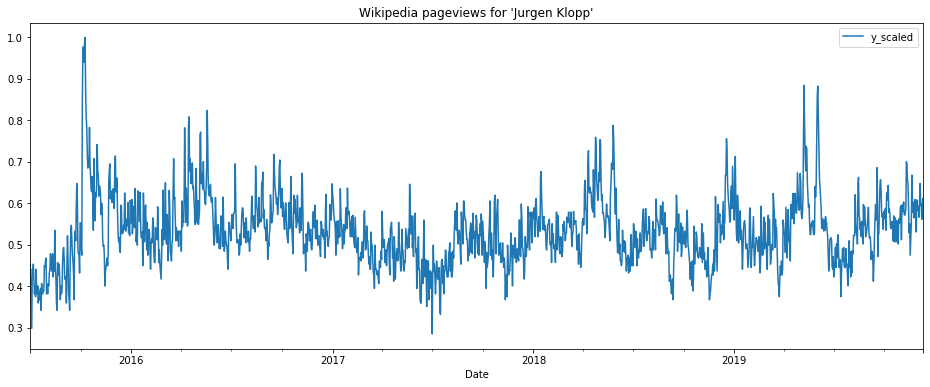

In [3]:
df = pd.read_csv('data/wikiklopp.csv').iloc[:-1]
# Make sure we work with datetime types
df['Date'] = pd.to_datetime(df['Date'])
# Scale the data
df['Jurgen Klopp']  = np.log(df['Jurgen Klopp'] )
df['y_scaled'] = df['Jurgen Klopp'] / df['Jurgen Klopp'].max()
df['t'] = (df['Date'] - df['Date'].min()) / (df['Date'].max() - df['Date'].min())
df.plot(x='Date', y='y_scaled', figsize=(16, 6), title="Wikipedia pageviews for 'Jurgen Klopp'")


In [4]:
def trend_model(m, t, n_changepoints=25, changepoints_prior_scale=0.05, 
                growth_prior_scale=5, changepoint_range=0.8):
    """
    The piecewise linear trend with changepoint implementation in PyMC3.
    :param m: (pm.Model)
    :param t: (np.array) MinMax scaled time.
    :param n_changepoints: (int) The number of changepoints to model.
    :param changepoint_prior_scale: (flt/ None) The scale of the Laplace prior on the delta vector.
                                    If None, a hierarchical prior is set.
    :param growth_prior_scale: (flt) The standard deviation of the prior on the growth.
    :param changepoint_range: (flt) Proportion of history in which trend changepoints will be estimated. 
    :return g, A, s: (tt.vector, np.array, tt.vector)
    """
    s = np.linspace(0, changepoint_range * np.max(t), n_changepoints + 1)[1:]
    
    # * 1 casts the boolean to integers
    A = (t[:, None] > s) * 1

    with m:
        # initial growth
        k = pm.Normal('k', 0 , growth_prior_scale)
        
        if changepoints_prior_scale is None:
            changepoints_prior_scale = pm.Exponential('tau', 1.5)
        
        # rate of change
        delta = pm.Laplace('delta', 0, changepoints_prior_scale, shape=n_changepoints)
        # offset
        m = pm.Normal('m', 0, 5)
        gamma = -s * delta
        
        g = (k + det_dot(A, delta)) * t + (m + det_dot(A, gamma))
    return g, A, s

# Generate a PyMC3 Model context
m = pm.Model()

with m:
    y, A, s = trend_model(m, df['t'])
    
    sigma = pm.HalfCauchy('sigma', 0.5, testval=1)
    pm.Normal('obs', 
                 mu=y,
                 sd=sigma,
              observed=df['y_scaled'])


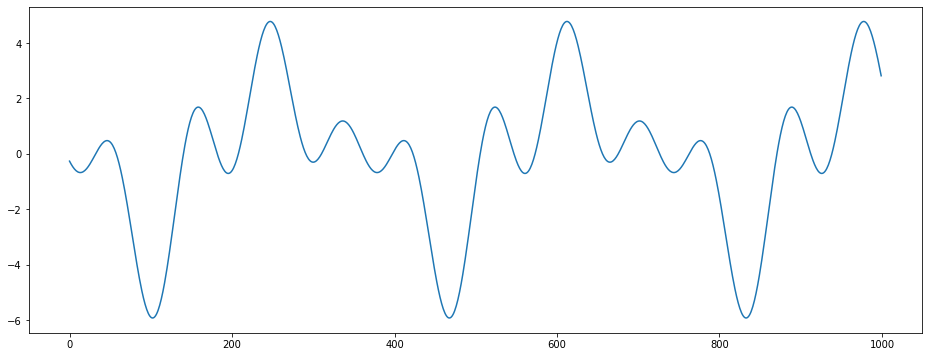

In [5]:
np.random.seed(6)
def fourier_series(t, p=365.25, n=10):
    # 2 pi n / p
    x = 2 * np.pi * np.arange(1, n + 1) / p
    # 2 pi n / p * t
    x = x * t[:, None]
    x = np.concatenate((np.cos(x), np.sin(x)), axis=1)
    return x

n = 4
t = np.arange(1000)
beta = np.random.normal(size=2 * n)
plt.figure(figsize=(16, 6))
plt.plot(fourier_series(t, 365.25, n) @ beta)


In [6]:
def seasonality_model(m, df, period='yearly', seasonality_prior_scale=10):
    
    if period == 'yearly':
        n = 10
        # rescale the period, as t is also scaled
        p = 365.25 / (df['Date'].max() - df['Date'].min()).days
    else:  # weekly
        n = 3
        # rescale the period, as t is also scaled
        p = 7 / (df['Date'].max() - df['Date'].min()).days
    x = fourier_series(df['t'], p, n)
    with m:
        beta = pm.Normal(f'beta_{period}', mu=0, sd=seasonality_prior_scale, shape=2 * n)
    return x, beta

m = pm.Model()

with m:
    # changepoints_prior_scale is None, so the exponential distribution
    # will be used as prior on \tau.
    y, A, s = trend_model(m, df['t'], changepoints_prior_scale=None)
    x_yearly, beta_yearly = seasonality_model(m, df, 'yearly')
    x_weekly, beta_weekly = seasonality_model(m, df, 'weekly')
    
    y += det_dot(x_yearly, beta_yearly) + det_dot(x_weekly, beta_weekly)
    
    sigma = pm.HalfCauchy('sigma', 0.5, testval=1)
    obs = pm.Normal('obs', 
                 mu=y, 
                 sd=sigma,
                 observed=df['y_scaled'])

In [ ]:
# takes 20 minutes on my laptop
with m:
    trace = pm.sample(1000)
pm.traceplot(trace)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_weekly, beta_yearly, m, delta, tau, k]
Sampling 4 chains:  55%|█████▍    | 3289/6000 [10:10<10:28,  4.31draws/s]

In [ ]:
def det_seasonality_posterior(beta, x):
    return np.dot(x, beta.T)

p = 0.025
# vector distributions
beta_yearly = trace['beta_yearly']
beta_weekly = trace['beta_weekly']
delta = trace['delta']

# scalar distributions
k = trace['k']
m = trace['m']

# determine the posterior by evaulating all the values in the trace.
trend_posterior = ((k + np.dot(A, delta.T)) * df['t'][:, None] + m + np.dot(A, (-s * delta).T)) * df['Jurgen Klopp'].max()

yearly_posterior = det_seasonality_posterior(beta_yearly, x_yearly) * df['Jurgen Klopp'].max()
weekly_posterior = det_seasonality_posterior(beta_weekly, x_weekly) * df['Jurgen Klopp'].max()

date = df['Date'].dt.to_pydatetime()
sunday = np.argmax(df['Date'].dt.dayofweek)
weekdays = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
idx_year = np.argmax(df['Date'].dt.dayofyear)

plt.figure(figsize=(16, 3*6))
b = 411
plt.subplot(b)
plt.title('total')
plt.plot(date,
         (trend_posterior + yearly_posterior + weekly_posterior).mean(1), lw=0.5)
plt.scatter(date, df['Jurgen Klopp'], s=0.5, color='black')

plt.subplot(b + 1)
plt.title('trend')
plt.plot(date, trend_posterior.mean(1))
quant = np.quantile(trend_posterior, [p, 1 - p], axis=1)
plt.fill_between(date, quant[0, :], quant[1, :], alpha=0.25)

plt.subplot(b + 2)
plt.title('yearly')
plt.plot(date[idx_year: idx_year + 365], yearly_posterior.mean(1)[idx_year: idx_year + 365])
quant = np.quantile(yearly_posterior, [p, 1 - p], axis=1)
plt.fill_between(date[idx_year: idx_year + 365],
                 quant[0, idx_year: idx_year + 365], quant[1, idx_year: idx_year + 365], alpha=0.25)

plt.subplot(b + 3)
plt.title('weekly')
plt.plot(weekdays, weekly_posterior.mean(1)[sunday: sunday + 7])
quant = np.quantile(weekly_posterior, [p, 1 - p], axis=1)
plt.fill_between(weekdays, quant[0, sunday: sunday + 7],
                 quant[1, sunday: sunday + 7], alpha=0.25)


## Prediction with uncertainty intervals

In [ ]:
n_samples = 1000
days = 150
history_points = df.shape[0]
probability_changepoint = n_changepoints / history_points

future = pd.DataFrame({'Date': pd.date_range(df['Date'].min(), 
                                           df['Date'].max() + pd.Timedelta(days, 'D'), 
                        df.shape[0] + days)})
future['t'] = (future['Date'] - df['Date'].min()) / (df['Date'].max() - df['Date'].min())

# vector distributions
beta_yearly = trace['beta_yearly'].mean(0)
beta_weekly = trace['beta_weekly'].mean(0)
delta = trace['delta'].mean(0)

# scalar distributions
k = trace['k'].mean()
m = trace['m'].mean()

trend_forecast = []
lambda_ = trace['tau'].mean()

for n in range(n_samples):
    new_changepoints = future['t'][future['t'] > 1].values
    sample = np.random.random(new_changepoints.shape)
    new_changepoints = new_changepoints[sample <= probability_changepoint]
    new_delta = np.r_[delta, 
                      stats.laplace(0, lambda_).rvs(new_changepoints.shape[0])]
    new_s = np.r_[s, new_changepoints]
    new_A = (future['t'][:, None] > new_s) * 1

    trend_forecast.append(((k + np.dot(new_A, new_delta)) * future['t']  + (m + np.dot(new_A, (-new_s * new_delta)))) * df['Jurgen Klopp'].max())
    
trend_forecast = np.array(trend_forecast)

date = future['Date'].dt.to_pydatetime()
plt.figure(figsize=(16, 4))
plt.title('Trend forecasts uncertainty')
plt.plot(date, trend_forecast.mean(0))
quant = np.quantile(trend_forecast, [0.2, 0.8], axis=0)
plt.fill_between(date, quant[0, :], quant[1, :], alpha=0.25)
